In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelBinarizer
from bs4 import BeautifulSoup
from requests import get
import re

In [2]:
train = pd.read_csv("flight_delays_train.csv")

# EDA

In [3]:
def preprocess(X):
    X["Flight"] = X["Origin"] + "-" + X["Dest"]
    X["Hour"] = X["DepTime"] // 100
    X["Month"] = X["Month"].apply(lambda x: x.replace("c-", ""))
    X["DayOfMonth"] = X["DayofMonth"].apply(lambda x: x.replace("c-", ""))
    X = X.drop(["DayofMonth"], axis=1)
    X["DayOfWeek"] = X["DayOfWeek"].apply(lambda x: x.replace("c-", ""))


    airport_to_state = pd.read_csv("airport_to_state.csv", usecols=["airport", "state"])
    X = X.merge(airport_to_state, left_on="Origin", right_on="airport", how="left")
    if "dep_delayed_15min" in X.columns:
        X["dep_delayed_15min"] = X["dep_delayed_15min"].map({"Y": 1, "N":0})
    
    return X

In [4]:
X = preprocess(train.copy())
X.head()

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Flight,Hour,DayOfMonth,airport,state
0,8,7,1934,AA,ATL,DFW,732,0,ATL-DFW,19,21,ATL,GA
1,4,3,1548,US,PIT,MCO,834,0,PIT-MCO,15,20,PIT,PA
2,9,5,1422,XE,RDU,CLE,416,0,RDU-CLE,14,2,RDU,NC
3,11,6,1015,OO,DEN,MEM,872,0,DEN-MEM,10,25,DEN,CO
4,10,6,1828,WN,MDW,OMA,423,1,MDW-OMA,18,7,MDW,IL


# Графики задержек сгруппированные по разным признакам

In [5]:
weekdays = [u"Пн", u"Вт", u"Ср", u"Чт", u"Пт", u"Сб", u"Вс"]
months = [u"Ян", u"Фев", u"Мар", u"Апр", u"Май", u"Июн", u"Июл", u"Авг", u"Сен", u"Окт", u"Ноя", u"Дек"]

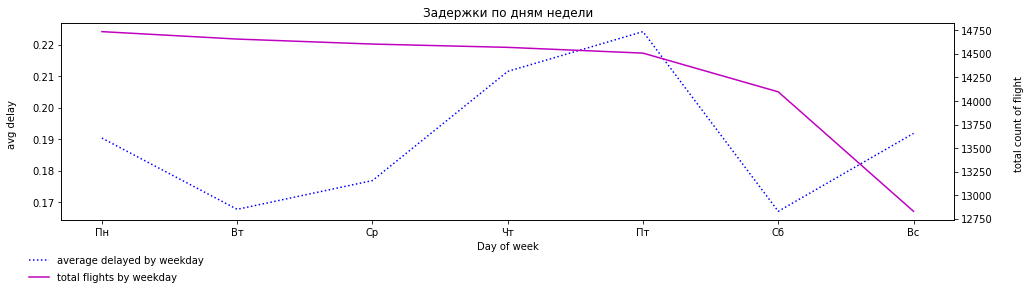

In [6]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,8), X.groupby("DayOfWeek").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by weekday")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,8), list(X["DayOfWeek"].value_counts()), color='m')
line2.set_label("total flights by weekday")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(4, 0.155, 'Day of week', ha='center')
ax0.text(0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(7.74, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Задержки по дням недели")
plt.xticks(range(1,8), weekdays)
plt.show()

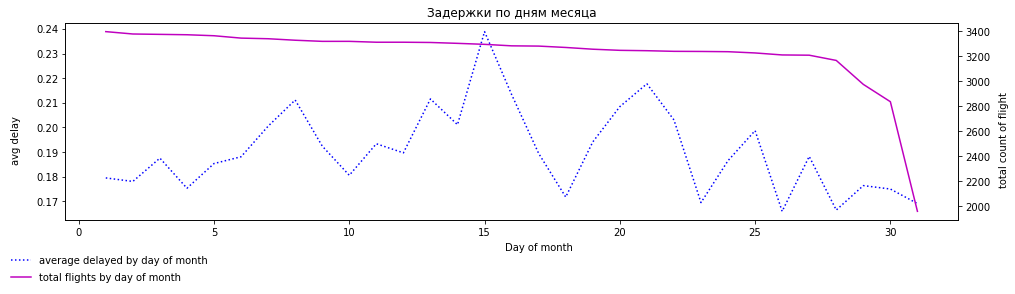

In [7]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,32), X.groupby("DayOfMonth").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by day of month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,32), list(X["DayOfMonth"].value_counts()), color='m')
line2.set_label("total flights by day of month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(17, 0.15, 'Day of month', ha='center')
ax0.text(-2.5, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(34, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Задержки по дням месяца")
plt.show()

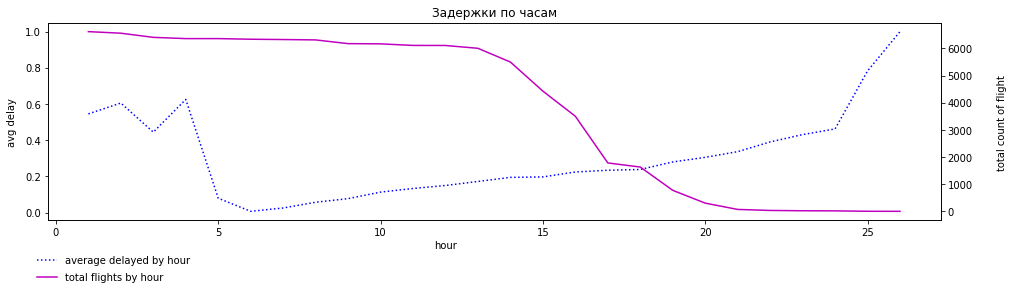

In [8]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,27), X.groupby("Hour").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by hour")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,27), list(X["Hour"].value_counts()), color='m')
line2.set_label("total flights by hour")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(12, -0.2, 'hour', ha='center')
ax0.text(-1.5, 0.5, 'avg delay', va='center', rotation='vertical')
ax0.text(29, 0.5, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Задержки по часам")
plt.show()

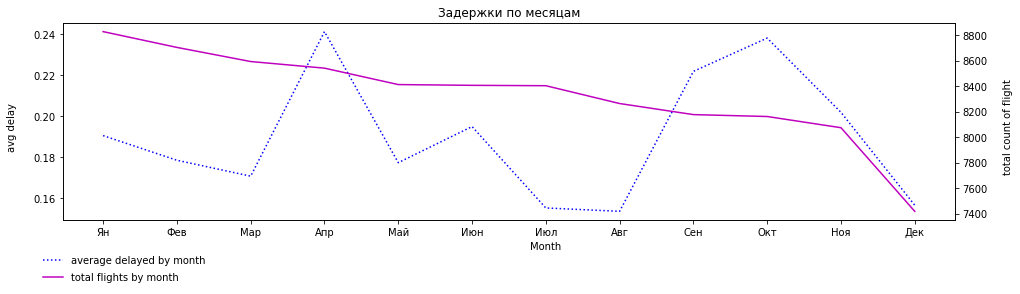

In [9]:
plt.figure(figsize=(16,8))
ax0 = plt.subplot(212)
ax1 = ax0.twinx()
line, = ax0.plot(range(1,13), X.groupby("Month").agg({"dep_delayed_15min": np.mean}), 'k:', color='b')
line.set_label("average delayed by month")
ax0.legend(bbox_to_anchor=(.17, -0.13), frameon = False)

line2, = ax1.plot(range(1,13), list(X["Month"].value_counts()), color='m')
line2.set_label("total flights by month")
ax1.legend(bbox_to_anchor=(.14, -0.22), frameon = False)

ax0.text(7, 0.135, 'Month', ha='center')
ax0.text(-0.3, 0.195, 'avg delay', va='center', rotation='vertical')
ax0.text(13.2, 0.195, 'total count of flight', va='center', rotation='vertical')
plt.title(u"Задержки по месяцам")
plt.xticks(range(1,13), months)
plt.show()

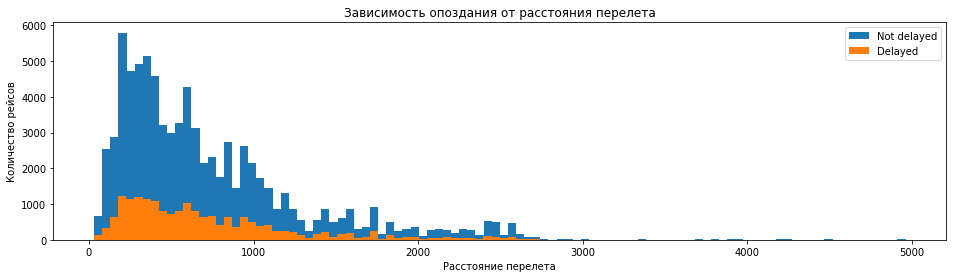

In [10]:
plt.figure(figsize=(16,4))
plt.hist(X['Distance'][X['dep_delayed_15min'] == 0], bins=100, label="Not delayed")
plt.hist(X['Distance'][X['dep_delayed_15min'] == 1], bins=100, label="Delayed")
plt.title(u"Зависимость опоздания от расстояния перелета")
plt.xlabel(u"Расстояние перелета")
plt.ylabel(u"Количество рейсов")
plt.legend()
plt.show()

# Проверим данные на корректность

In [11]:
# Проверяем, что расстояние между всеми пунктами не меняется
Z = X.groupby("Flight").agg({"Distance": [np.max, np.min]})
np.sum(Z["Distance"]["amax"] - Z["Distance"]["amin"]) == 0

True

In [12]:
# Количество различных аэропортов назначения и отбытия
len(X["Dest"].unique()), len(X["Origin"].unique())

(289, 289)

In [13]:
# Количество уникальных перелетов и дистанций
len(np.unique(X['Flight'])), len(np.unique(X['Distance']))

(4429, 1310)

# Тепловая карта 

In [14]:
import os
import folium
import json
import branca.colormap as cm

In [15]:
linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=1)
linear

In [16]:
state_json_data = json.load(open("us-states.json"))
states_delay = X.groupby("state").agg([np.mean])["dep_delayed_15min"]
states = [x["id"] for x in state_json_data["features"]]
flight_delay_states = states_delay.index.tolist()

In [17]:
# штаты, которых нет в геоданных. Это Пуэрто Рико и Виргинские острова.
set(flight_delay_states) - set(states)

{'PR', 'VI'}

In [18]:
# переводим вероятность задержки в 0-1
max_delay = states_delay.max()
min_delay = states_delay.min()
states_delay /= (max_delay - min_delay)

In [19]:
m = folium.Map([43, -100], tiles='cartodbpositron', zoom_start=4)

folium.GeoJson(
    state_json_data,
    style_function=lambda feature: {
        'fillColor': linear(states_delay.get_value(feature['id'], "mean")),
        'color': 'black',
        'weight': 2,
        'dashArray': '5'
    }).add_to(m)

m

# отладка всякая

In [20]:
# get_state_by_airport_code("AKN")

In [21]:
# air = pd.DataFrame(airports, columns=["airport"])
# st = pd.DataFrame(states, columns=["state"])
# airport_to_state = pd.concat([air, st], axis=1)
# airport_to_state.at['YUM', 'state'] = "AZ"
# airport_to_state.at['FCA', 'state'] = 'MT'
# airport_to_state.at['MQT', 'state'] = 'MI'
# airport_to_state.at['SJU', 'state'] = 'PR' # Пуэрто Рико
# airport_to_state.at['ISO', 'state'] = 'NC'
# airport_to_state.at['CLD', 'state'] = 'CA'
# airport_to_state.at['TUP', 'state'] = 'MS'
# airport_to_state.at['MEI', 'state'] = 'MS'
# airport_to_state.at['SCE', 'state'] = 'PA'
# airport_to_state.at['STT', 'state'] = 'VI' # Virgin Island
# airport_to_state.at['STX', 'state'] = 'VI'# Virgin Island
# airport_to_state.at['VIS', 'state'] = 'CA'
# airport_to_state.at['IPL', 'state'] = 'CA'
# airport_to_state.at['PFN', 'state'] = 'FL'
# airport_to_state.at['OXR', 'state'] = 'CA'
# airport_to_state.at['IYK', 'state'] = 'CA'
# airport_to_state.at['BQN', 'state'] = 'PR' # Пуэрто Рико
# airport_to_state.at['CDC', 'state'] = 'UT'
# airport_to_state.at['APF', 'state'] = 'FL'
# airport_to_state.at['MCN', 'state'] = 'GA'
# airport_to_state.at['ILG', 'state'] = 'DE'
# airport_to_state.at['OTZ', 'state'] = 'AK'
# airport_to_state.at['HKY', 'state'] = 'NA'
# airport_to_state.at['SOP', 'state'] = 'NA'
# airport_to_state.at['WYS', 'state'] = 'MT'
# airport_to_state.at['PSE', 'state'] = 'PR' # Пуэрто Рико
# airport_to_state.at['TEX', 'state'] = 'CO'
# airport_to_state.at['VCT', 'state'] = 'TX'
# airport_to_state.at["MSP", 'state'] = "MN"

In [22]:
# airport_to_state.to_csv("airport_to_state.csv")